# Towards Understanding the Bias-Variance Tradeoff

Heres the famous bias-variance tradeoff in one chart:
![Bias-variance tradeoff](../images/bias_variance.png)

*variance* = error from training set; *total error* = testing set

We are going to try to understand it using some data.

Here's another chart, mirroring the famous bias-variance one above, except involving train/test errors and 3 example machine learning models found on 3 points on the curve. 

In this case, let's assume we have a simple problem involving predicting happiness quantified in some way, by using how much wealth a given person has as our single feature:
![traintest](../images/training_testing_error.png)

**Our goal is to develop an intuitive understanding for why both of these curves hold for ANY MACHINE LEARNING PROBLEM YOU WILL EVER ENCOUNTER!**

Let's import what we will use for this exploration:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline

## Dataset: Brain weight vs. body weight

This is a dataset of the average weight of the body and the brain for 62 mammal species. Let's read it into pandas and take a quick look:

In [2]:
df = pd.read_table('../data/body_vs_brain_weight.txt', 
                   sep='\s+', 
                   skiprows=33, 
                   names=['id','brain','body'], 
                   index_col='id')
df.head()

,brain,body
id,,
1,3.385,44.5
2,0.480,15.5
3,1.350,8.1
4,465.000,423.0
5,36.330,119.5


In [3]:
df.describe()

,brain,body
count,62.000000,62.000000
mean,198.789984,283.134194
std,899.158011,930.278942
min,0.005000,0.140000
25%,0.600000,4.250000
50%,3.342500,17.250000
75%,48.202500,166.000000
max,6654.000000,5712.000000


We're going to focus on a smaller subset in which the body weight is less than 800 as there are 3 massive outliers (guess what mammals those are).

Here's a scatterplot (using [**Seaborn**](http://stanford.edu/~mwaskom/software/seaborn/)) of the relationship between average brain and body weight:

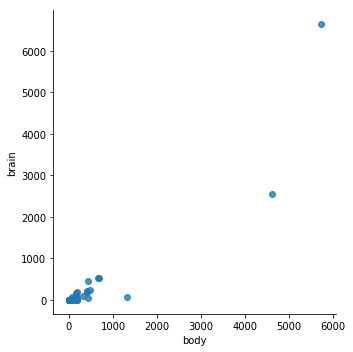

In [4]:
sns.lmplot(x = 'body', 
           y = 'brain', 
           data = df, 
           ci = None, 
           fit_reg = False)

In [5]:
# only keep rows in which the body weight is less than 1000
df = df[df.body < 800]
df.shape

(59, 2)

So, for the purposes of this exploration, we're actually going to pretend that there are only 59 mammal species in existence. In other words, **we are pretending that this is the entire dataset of average brain and body weights for every known mammal species**:

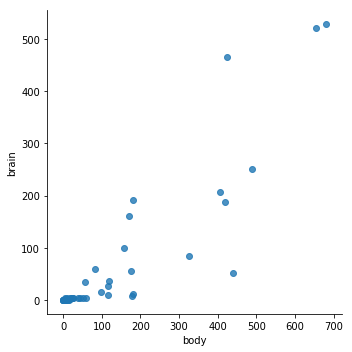

In [6]:
sns.lmplot(x='body', y='brain', data=df, ci=None, fit_reg=False)

Cool, there appears to be a relationship between brain weight and body weight for mammals.

## Making a prediction from all the data

Now let's pretend that a **new mammal species** is discovered. We measure the body weight of every member of this species that we can find, and calculate an **average body weight of 200**. We want to **predict the average brain weight** of this species (rather than measuring it directly):

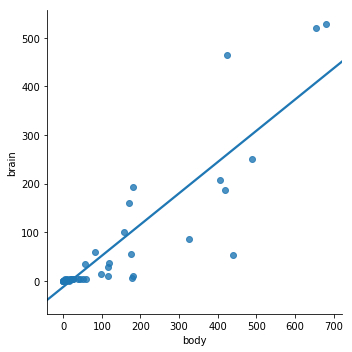

In [7]:
sns.lmplot(x = 'body', y = 'brain', 
           data = df, 
           ci = None)

Let's build a model equivalent to the fitted line above using `sklearn` and make a prediction for the brain weight of a species whose average body weight is 200:

In [9]:
lm = LinearRegression()
lm.fit(df["body"].values.reshape((-1,1)),df["brain"])
print("linear prediction on all the data: ",lm.predict(np.array([[200]]))[0])

linear prediction on all the data:  115.93566471367103


## Making a prediction from a sample

Earlier, I said that this dataset contained every known mammal species. 

That's very convenient, but **in the real world, all you ever have is a sample of data**. A more realistic situation would be to only have brain and body weights for some unknown fraction of the 59 known mammals.

When some new mammal species (with a body weight of 100) is discovered, we still want to make an accurate prediction for the brain weight, but **this task will be more difficult since we don't have all of the data that we would ideally like to have.**

Let's simulate this situation by assigning each of the 59 rows to **one of 3 sample sets**. Think of them as 4 different possible worlds where a different, non-overlapping fraction of the 59 known mammal species had been discovered.

In [10]:
# set a random seed for reproducibility
np.random.seed(12345)

# randomly assign every row to one of 3 samples
df['sample'] = np.random.randint(1, 4, len(df))
df.head()

,brain,body,sample
id,,,
1,3.385,44.5,3
2,0.480,15.5,2
3,1.350,8.1,2
4,465.000,423.0,2
5,36.330,119.5,1


We can now create three different plots, in which the each plot only uses the data from the given possible world:

(-10, 600)

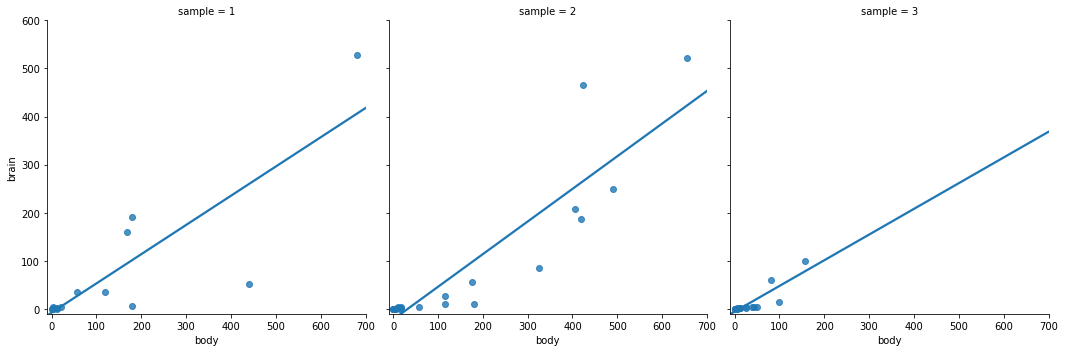

In [11]:
# col='sample' subsets the data by sample and creates two separate plots
sns.lmplot(x='body', y='brain', data=df, ci=None, col='sample')
sns.mpl.pyplot.xlim(-10, 700)
sns.mpl.pyplot.ylim(-10, 600)

The line looks pretty similar between the plots, despite the fact that they used separate samples of data. In all three possible worlds, we would predict a brain weight of ~100-120.

It's easier to see the degree of similarity by placing them on the same plot:

(-10, 600)

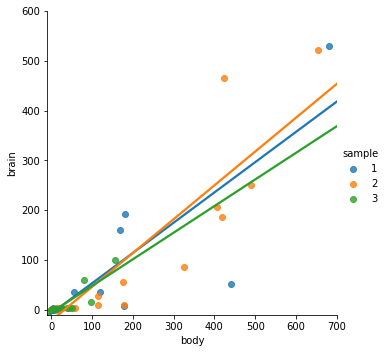

In [12]:
# hue='sample' subsets the data by sample and creates a single plot
sns.lmplot(x='body', y='brain', data=df, ci=None, hue='sample')
sns.mpl.pyplot.xlim(-10, 700)
sns.mpl.pyplot.ylim(-10, 600)

In [14]:
lm1 = LinearRegression()
lm2 = LinearRegression()
lm3 = LinearRegression()

lm1.fit(df["body"][df["sample"]==1].values.reshape((-1,1)),df["brain"][df["sample"]==1])
lm2.fit(df["body"][df["sample"]==2].values.reshape((-1,1)),df["brain"][df["sample"]==2])
lm3.fit(df["body"][df["sample"]==3].values.reshape((-1,1)),df["brain"][df["sample"]==3])

print(lm1.predict(np.array([[200]])).round(2))
print(lm2.predict(np.array([[200]])).round(2))
print(lm3.predict(np.array([[200]])).round(2))

[113.94]
[113.88]
[101.28]


What was the point of this exercise? This was a demonstration of a **high bias, low variance model**:

- It's **high bias** because it doesn't fit the data particularly well.
- It's **low variance** because it doesn't change much depending upon which points happen to be in the sample.

## Overfitting

What would a **low bias, high variance** model look like?

Let's try using polynomial regression, with a 5th order polynomial (this is like the `KernelRidge` regression model we used in the first week, where `degree=5`):

(-10, 600)

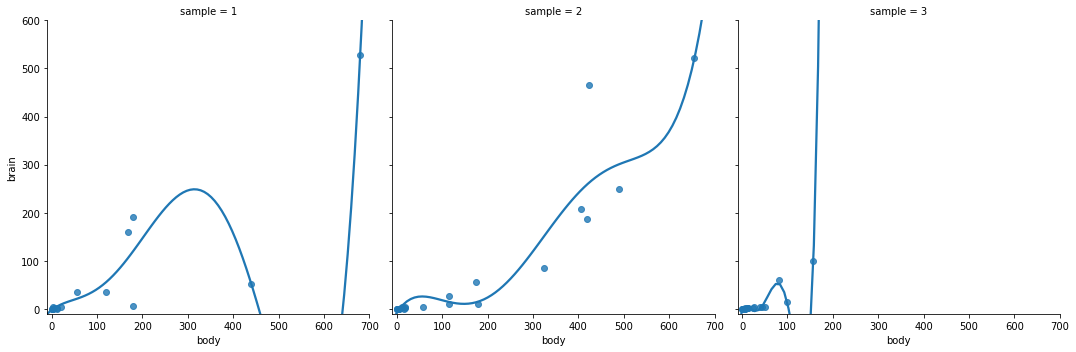

In [15]:
sns.lmplot(x='body', y='brain', data=df, ci=None, col='sample', order=5)
sns.mpl.pyplot.xlim(-10, 700)
sns.mpl.pyplot.ylim(-10, 600)

And the same thing in a single plot:

(-10, 600)

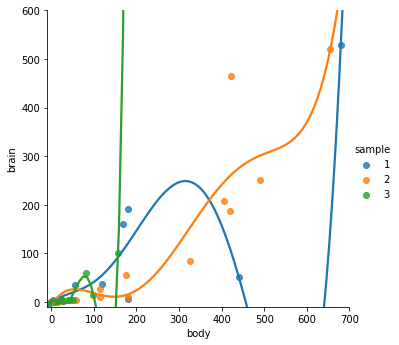

In [16]:
sns.lmplot(x='body', y='brain', data=df, ci=None, hue='sample',order=5)
sns.mpl.pyplot.xlim(-10, 700)
sns.mpl.pyplot.ylim(-10, 600)

And now let's fit a 5th order polynomial model to the data (equivalent to the curves we drew above) using some helper functions from `numpy`:

In [17]:
#3 different fits
pm1 = np.polyfit(df["body"][df["sample"]==1].values, df["brain"][df["sample"]==1].values, 5)
pm2 = np.polyfit(df["body"][df["sample"]==2].values, df["brain"][df["sample"]==2].values, 5)
pm3 = np.polyfit(df["body"][df["sample"]==3].values, df["brain"][df["sample"]==3].values, 5)

#3 different predictions
p1 = np.poly1d(pm1)
print(p1(200).round(2))
p2 = np.poly1d(pm2)
print(p2(200).round(2))
p3 = np.poly1d(pm3)
print(p3(200).round(2))

146.85
23.91
4406.79


Here the predictions of each model vary widely (widely being an understatement), with predicted brain weights ranging between ~20 to over 4400! **That's a prediction difference of over 2 ORDERS OF MAGNITUDE FOR THE SAME EXACT SAMPLE!**

This is an example of a **low bias high variance** model because:

- It's **low bias** because each individual model matches the data sample it was trained on quite well!
- It's **high variance** because each model gives widely differing predictions depending upon which points happen to be in the sample.

## Can we find a middle ground?

Perhaps we can create a model that has **less bias than the linear model**, and **less variance than the fifth order polynomial**?

Let's try a second order polynomial instead:

(-10, 600)

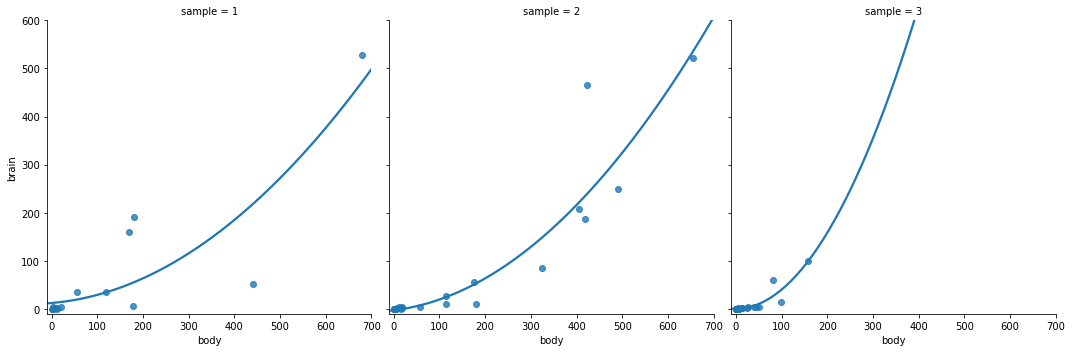

In [18]:
sns.lmplot(x='body', y='brain', data=df, ci=None, col='sample', order=2)
sns.mpl.pyplot.xlim(-10, 700)
sns.mpl.pyplot.ylim(-10, 600)

(-10, 600)

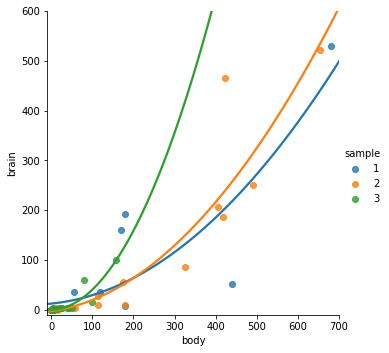

In [18]:
sns.lmplot(x='body', y='brain', data=df, ci=None, hue='sample', order=2)
sns.mpl.pyplot.xlim(-10, 700)
sns.mpl.pyplot.ylim(-10, 600)

In [20]:
#3 different fits
pm1 = np.polyfit(df["body"][df["sample"]==1].values, df["brain"][df["sample"]==1].values, 2)
pm2 = np.polyfit(df["body"][df["sample"]==2].values, df["brain"][df["sample"]==2].values, 2)
pm3 = np.polyfit(df["body"][df["sample"]==3].values, df["brain"][df["sample"]==3].values, 2)

#3 different predictions
p1 = np.poly1d(pm1)
print(p1(200).round(2))
p2 = np.poly1d(pm2)
print(p2(200).round(2))
p3 = np.poly1d(pm3)
print(p3(200).round(2))

63.8
63.68
158.65


This seems better. In each plot, **it fits the data pretty well, but not too well**.

This is the **bias-variance tradeoff** in a nutshell: 

**Find a model that appropriately balances bias and variance, and thus will generalize to new data (what we have called "out of sample" data).**

![traintest](../images/training_testing_error.png)
![Bias-variance tradeoff](../images/bias_variance.png)